<a href="https://colab.research.google.com/github/viniciusacosta/rent_calculator/blob/main/machine_learning/model_imoveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importando Bibliotecas**

In [212]:
## Importando bibliotecas necessárias para o projeto
# Bibliotecas para a manipulação, exploração dos e visualização do conjuntos de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas de aprendizado de máquina
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from yellowbrick.contrib.wrapper import wrap
from sklearn.linear_model import RidgeCV, Lasso, ElasticNet, LassoLars, HuberRegressor, LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Bibliotecas para avaliação dos modelos.
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import pickle
import time
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Carregando dados**

In [213]:
# Carregando conjunto de dados.
df = pd.read_csv('/content/drive/MyDrive/data_science/imoveis/apto_capitais_data.csv')

# Exibindo as primeiras linhas do DataFrame
df.head()

,Unnamed: 0,crawled_at,estado,city,address,area,rooms,bathrooms,garage,price_rent,...,varanda_fechada_com_vidro,varanda_gourmet,ventilacao_natural,vestiario,vigia,vista_exterior,vista_para_a_montanha,vista_para_o_mar,area_de_lazer,area_de_servico
0,2,2022-06-23 21:10:00,SE,aracaju,"Rua Maria Vasconcelos de Andrade, 1720 - Aruan...",80.0,3.0,2.0,1.0,750.0,...,0,0,0,0,0,0,0,0,0,0
1,3,2022-06-23 21:10:00,SE,aracaju,"Luzia, Aracaju - SE",67.0,2.0,1.0,1.0,1250.0,...,0,0,0,0,0,0,0,0,0,0
2,4,2022-06-23 21:10:00,SE,aracaju,"Avenida São João Batista, 638 - Ponto Novo, Ar...",70.0,3.0,1.0,1.0,1200.0,...,0,0,0,0,0,0,0,0,0,1
3,5,2022-06-23 21:10:00,SE,aracaju,"Rua Matilde Silva Lima, 421 - Luzia, Aracaju - SE",65.0,3.0,1.0,1.0,800.0,...,0,0,0,0,0,0,0,0,0,0
4,6,2022-06-23 21:10:00,SE,aracaju,"Luzia, Aracaju - SE",59.0,3.0,1.0,1.0,850.0,...,0,0,0,0,0,0,0,0,0,1


In [214]:
# Retirando colunas indesejadas
df.drop(columns=['Unnamed: 0', '...'], inplace=True)

# Resultado da transformação
df.columns.values

array(['crawled_at', 'estado', 'city', 'address', 'area', 'rooms',
       'bathrooms', 'garage', 'price_rent', 'condo', 'academia',
       'aceita_animais', 'acesso_para_deficientes', 'aquecimento',
       'ar-condicionado', 'armario_embutido',
       'armario_embutido_no_quarto', 'armario_na_cozinha',
       'armario_no_banheiro', 'banheiro_de_servico', 'bicicletario',
       'box_blindex', 'cabeamento_estruturado', 'churrasqueira',
       'churrasqueira_na_varanda', 'chuveiro_a_gas',
       'circuito_de_seguranca', 'closet', 'condominio_fechado',
       'conexao_a_internet', 'copa', 'cozinha', 'cozinha_americana',
       'cozinha_grande', 'camera_de_seguranca',
       'dependencia_de_empregados', 'deposito', 'elevador', 'escada',
       'escritorio', 'espaco_gourmet', 'espaco_verde_/_parque',
       'estacionamento_para_visitantes', 'garagem', 'gerador_eletrico',
       'gesso_-_sanca_-_teto_rebaixado', 'guarita', 'gas_encanado',
       'hall_de_entrada', 'hidromassagem', 'interfone'

In [215]:
# Verificando as dimensões do dataset.
df.shape

(2659, 103)

## **Análise Exploratória dos Dados**

In [216]:
df[["area", "rooms", "bathrooms", "garage", 'condo', "price_rent"]].describe().T

,count,mean,std,min,25%,50%,75%,max
area,2659.0,92.060925,1.089451e+02,10.0,55.0,73.0,103.0,4700.0
rooms,2659.0,2.282813,9.231829e-01,1.0,2.0,2.0,3.0,7.0
bathrooms,2659.0,2.001880,1.170716e+00,1.0,1.0,2.0,3.0,8.0
garage,2659.0,1.254983,1.085357e+00,0.0,1.0,1.0,2.0,30.0
condo,2659.0,38678.903723,1.939297e+06,1.0,363.0,600.0,931.5,100000000.0
price_rent,2659.0,3909.618278,3.041381e+04,395.0,1350.0,2100.0,3400.0,1300000.0


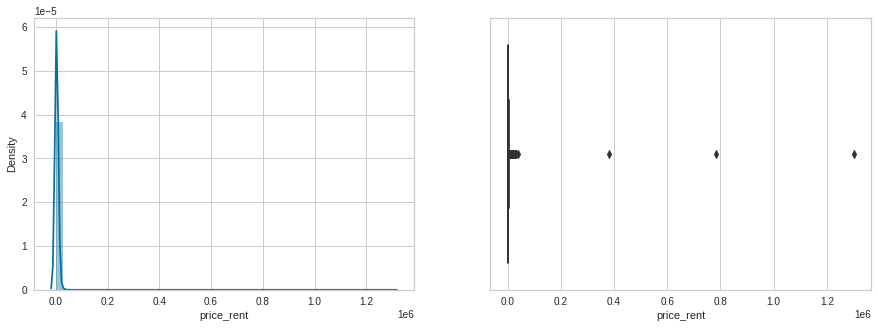

In [218]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(df['price_rent'], ax = axes[0])
sns.boxplot(df['price_rent'], ax = axes[1])
plt.show()

In [219]:
df[df.price_rent >= 40000]

,crawled_at,estado,city,address,area,rooms,bathrooms,garage,price_rent,condo,...,varanda_fechada_com_vidro,varanda_gourmet,ventilacao_natural,vestiario,vigia,vista_exterior,vista_para_a_montanha,vista_para_o_mar,area_de_lazer,area_de_servico
210,2022-06-23 21:21:00,BA,salvador,"Avenida Sete de Setembro, 1682 - Vitória, Salv...",350.0,4.0,4.0,5.0,40000.0,3500.0,...,0,0,0,0,0,0,0,0,0,0
771,2022-06-23 21:39:00,RN,natal,"Rua Doutor Múcio Galvão, 459 - Tirol, Natal - RN",163.0,3.0,2.0,3.0,380000.0,1350.0,...,0,0,0,0,0,0,0,0,0,0
1568,2022-06-23 21:56:00,RJ,rio-de-janeiro,"Flamengo, Rio de Janeiro - RJ",70.0,1.0,1.0,0.0,1300000.0,100000000.0,...,0,0,0,0,0,0,0,0,0,0
1585,2022-06-23 21:56:00,RJ,rio-de-janeiro,"Rua Ribeiro Guimarães - Vila Isabel, Rio de Ja...",78.0,2.0,2.0,1.0,785000.0,1200.0,...,0,0,0,0,0,0,0,0,0,0


Podemos observar a presença de alguns outliers nos valores de aluguel (price_rent), possivelmente sendo o preço de venda do imóvel, o que indica algum erro de digitação ou na captação dos dados.

Vemos também que os outliers começam próximo aos 40000.

In [220]:
# Removendo imóveis com valores de venda
df = df.drop(df[df.price_rent >= 40000].index)

In [221]:
df[["area", "rooms", "bathrooms", "garage", 'condo', "price_rent"]].describe().T

,count,mean,std,min,25%,50%,75%,max
area,2655.0,91.950659,108.902178,10.0,55.0,73.0,103.0,4700.0
rooms,2655.0,2.282486,0.922820,1.0,2.0,2.0,3.0,7.0
bathrooms,2655.0,2.001507,1.170794,1.0,1.0,2.0,3.0,8.0
garage,2655.0,1.253484,1.082923,0.0,1.0,1.0,2.0,30.0
condo,2655.0,1070.114878,11923.118613,1.0,361.5,600.0,930.0,600000.0
price_rent,2655.0,2972.005650,2982.994115,395.0,1350.0,2100.0,3400.0,30000.0


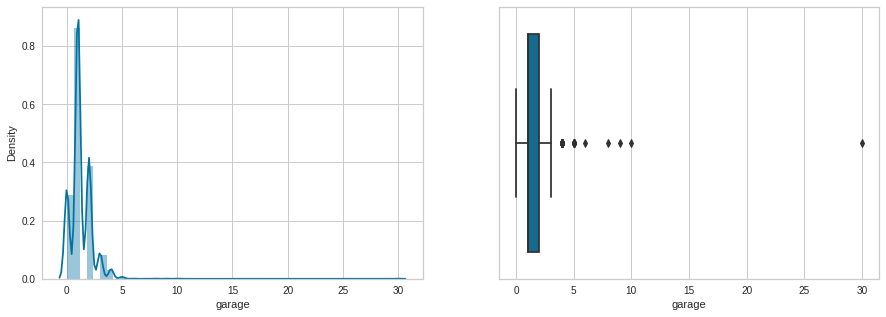

In [223]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(df['garage'], ax = axes[0])
sns.boxplot(df['garage'], ax = axes[1])
plt.show()

In [224]:
df[df.garage >= 8]

,crawled_at,estado,city,address,area,rooms,bathrooms,garage,price_rent,condo,...,varanda_fechada_com_vidro,varanda_gourmet,ventilacao_natural,vestiario,vigia,vista_exterior,vista_para_a_montanha,vista_para_o_mar,area_de_lazer,area_de_servico
1096,2022-06-23 21:48:00,MG,belo-horizonte,"Rua Rio Grande do Norte, 1299 - Funcionários, ...",65.0,1.0,1.0,30.0,1600.0,290.0,...,0,0,0,0,0,0,0,0,0,0
2222,2022-06-23 22:06:00,SP,sao-paulo,"Rua João Antônio de Oliveira, 55 - Móoca, São ...",100.0,3.0,3.0,10.0,4800.0,950.0,...,0,0,0,0,0,0,0,0,0,0
2336,2022-06-23 22:07:00,SP,sao-paulo,"Avenida Aratãs, 650 - Moema, São Paulo - SP",93.0,2.0,3.0,9.0,4000.0,1345.0,...,0,0,0,0,0,0,0,0,0,0
2542,2022-06-23 22:14:00,DF,brasilia,"CA 10, 302 - Lago Norte, Brasília - DF",88.0,2.0,1.0,8.0,4300.0,850.0,...,0,0,0,0,0,0,0,0,0,0


Existem imóveis com valores bastantes altos de vagas na garagem, valores esses que talvez sejam resultado de erros de digitação. Por serem poucos imóveis, irei removê-los.

In [225]:
# Removendo imóveis com valores exagerados de vagas na garagem (garage)
df = df.drop(df[df.garage >= 8].index)

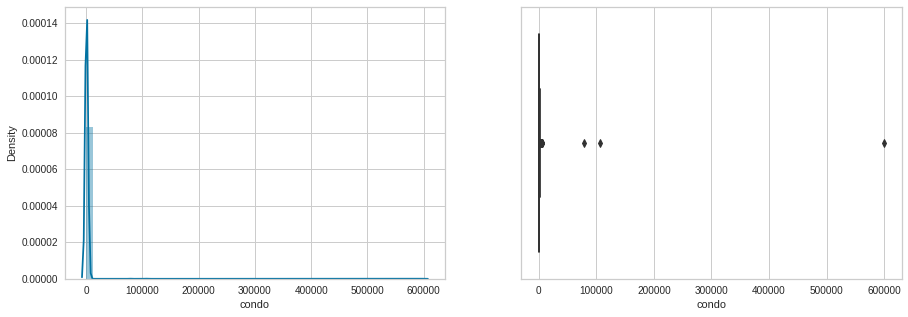

In [227]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.distplot(df['condo'], ax = axes[0])
sns.boxplot(df['condo'], ax = axes[1])
plt.show()

In [228]:
df[df.condo >= 10000]

,crawled_at,estado,city,address,area,rooms,bathrooms,garage,price_rent,condo,...,varanda_fechada_com_vidro,varanda_gourmet,ventilacao_natural,vestiario,vigia,vista_exterior,vista_para_a_montanha,vista_para_o_mar,area_de_lazer,area_de_servico
726,2022-06-23 21:35:00,PE,recife,"Rua dos Navegantes - Boa Viagem, Recife - PE",95.0,3.0,3.0,2.0,2300.0,107000.0,...,0,0,0,0,0,0,0,0,0,0
1529,2022-06-23 21:55:00,RJ,rio-de-janeiro,"Rua Almirante Alexandrino, 16 - Santa Teresa, ...",75.0,2.0,1.0,0.0,2200.0,600000.0,...,0,0,0,0,0,0,0,0,0,0
2190,2022-06-23 22:05:00,SP,sao-paulo,"Rua André Casado, 215 - Sumaré, São Paulo - SP",50.0,1.0,1.0,1.0,6000.0,78140.0,...,0,0,0,0,0,0,0,0,0,0


Assim como as features anteriores, existem imóveis com valores de condominio altissimos que talvez sejam resultado de erros de digitação. Por serem poucos imóveis, irei removê-los.

In [229]:
# Removendo imóveis com outliers de condominio (condo)
df = df.drop(df[df.condo >= 10000].index)

##**Separando as features em grupos**

In [230]:
# Separando as colunas em grupos
target = "price_rent"
numerical_features = ["area", "rooms", "bathrooms", "garage", 'condo']
categorical_features = ["city", "estado"]
binary_features = ['academia',
       'aceita_animais', 'acesso_para_deficientes', 'aquecimento',
       'ar-condicionado', 'armario_embutido',
       'armario_embutido_no_quarto', 'armario_na_cozinha',
       'armario_no_banheiro', 'banheiro_de_servico', 'bicicletario',
       'box_blindex', 'cabeamento_estruturado', 'churrasqueira',
       'churrasqueira_na_varanda', 'chuveiro_a_gas',
       'circuito_de_seguranca', 'closet', 'condominio_fechado',
       'conexao_a_internet', 'copa', 'cozinha', 'cozinha_americana',
       'cozinha_grande', 'camera_de_seguranca',
       'dependencia_de_empregados', 'deposito', 'elevador', 'escada',
       'escritorio', 'espaco_gourmet', 'espaco_verde_/_parque',
       'estacionamento_para_visitantes', 'garagem', 'gerador_eletrico',
       'gesso_-_sanca_-_teto_rebaixado', 'guarita', 'gas_encanado',
       'hall_de_entrada', 'hidromassagem', 'interfone',
       'janela_de_aluminio', 'janela_grande', 'jardim', 'lareira',
       'lavabo', 'lavanderia', 'mais_de_um_andar', 'mobiliado',
       'movel_planejado', 'none', 'perto_de_vias_de_acesso', 'piscina',
       'piscina_infantil', 'piscina_para_adulto', 'piscina_privativa',
       'piso_de_madeira', 'piso_frio', 'piso_vinilico', 'playground',
       'porcelanato', 'portaria_24h', 'portao_eletronico',
       'proximo_a_escola', 'proximo_a_hospitais', 'proximo_a_shopping',
       'proximo_a_transporte_publico', 'pe_direito_alto',
       'quadra_de_tenis', 'quadra_poliesportiva', 'quarto_de_servico',
       'quintal', 'recepcao', 'sala_de_jantar', 'sala_de_massagem',
       'salao_de_festas', 'salao_de_jogos', 'sauna', 'seguranca_24h',
       'sistema_de_alarme', 'spa', 'tv_a_cabo', 'varanda',
       'varanda_fechada_com_vidro', 'varanda_gourmet',
       'ventilacao_natural', 'vestiario', 'vigia', 'vista_exterior',
       'vista_para_a_montanha', 'vista_para_o_mar', 'area_de_lazer',
       'area_de_servico']

## **Criando funções auxiliares**

In [231]:
### Criando Funções
## Holdout treino e teste
def get_train_test(X, Y,test_size_p):
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size_p, random_state=42)
  return x_train, x_test, y_train, y_test


## Aplicação dos modelos
# Modelo de Regressão Linear
def model_linear_apply(model, x_train, x_test, y_train):
  lm = model()
  lm.fit(x_train, y_train)
  yHat = lm.predict(x_test)
  return yHat

# Avaliação do modelo
def evaluate_model(y_test, yHat):
  ax1=sns.distplot(y_test, hist=False, color='r', label='Valor Real')
  sns.distplot(yHat, hist=False, ax=ax1, color='b', label='Valor Previsto')
  plt.legend()
  plt.show()
  stats = pd.DataFrame({  
      'R2'    : r2_score(y_test, yHat),
      'MAE'    : mean_absolute_error(y_test, yHat),  
      'MSE'   : mean_squared_error(y_test, yHat), 
      'RMSE'  : np.sqrt(mean_squared_error(y_test, yHat))
      }, index = ['RESULT'])
  return stats


## Criando Pipeline de trabalho
# Regressão Linear 
def pipeline_linear(X, Y, model, test_size_p):
  x_train, x_test, y_train, y_test = get_train_test(X, Y, test_size_p)
  yHat = model_linear_apply(model, x_train, x_test, y_train)
  stats = evaluate_model(y_test, yHat)
  return stats

##**Baseline**

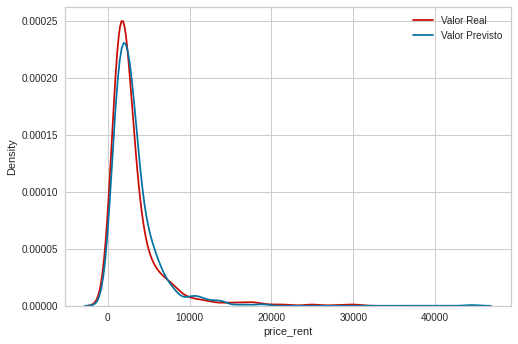

,R2,MAE,MSE,RMSE
RESULT,0.490704,1193.621887,6.379206e+06,2525.709086


In [232]:
x_target = df[numerical_features + binary_features]
y_target = df[target]

# Modelo Linear
pipeline_linear(  
    X = x_target,   
    Y = y_target,   
    model = LinearRegression, 
    test_size_p = 0.3 
    )

#**Holdout treino e teste**


In [233]:
## Normalização das features númericas e aplicação do OneHotEncoder nas features categóricas
# MinMaxScaler
scaler = MinMaxScaler()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features)],
                                  remainder = "passthrough")

# Fitando o modelo para realizar as transformações
#data_pipeline.fit(x_train)

# Transformando as colunas
x_train_transformed = data_pipeline.fit_transform(x_train) 
x_test_transformed = data_pipeline.transform(x_test)

# Transformando o array em um DataFrame
x_train_transformed = pd.DataFrame(x_train_transformed, columns=numerical_features+categorical_features+binary_features)
x_test_transformed = pd.DataFrame(x_test_transformed, columns=numerical_features+categorical_features+binary_features)

# **Feature selection**

In [234]:
selector = SelectKBest(score_func=mutual_info_regression, k="all")
selector.fit(x_train_transformed[numerical_features+binary_features], y_train)

best_features = pd.DataFrame(zip(numerical_features + binary_features, selector.scores_), columns=["feature", "score"]).sort_values("score", ascending=False).head(10)
best_features

,feature,score
4,condo,0.410347
0,area,0.276129
2,bathrooms,0.249897
3,garage,0.223971
1,rooms,0.143278
57,piscina,0.058099
5,academia,0.055452
32,elevador,0.047503
53,mobiliado,0.036643
54,movel_planejado,0.035003


# **Fitting model**

In [249]:
# Lista de modelos a serem treinados
reg_list = [RidgeCV(),
            Lasso(),
            ElasticNet(), 
            HuberRegressor(),
            LGBMRegressor(), 
            XGBRegressor(objective='reg:squarederror'),
            SVR(),
            KNeighborsRegressor(),
            RandomForestRegressor(),
            AdaBoostRegressor(),
            GradientBoostingRegressor(),
            MLPRegressor()
            ]

In [250]:
## Normalização das features númericas e aplicação do OneHotEncoder nas features categóricas
scaler = MinMaxScaler()
ohe = OneHotEncoder()

# Criando a variável data_pipeline para deixar na mesma ordem de grandeza minhas variáveis numericas
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features),
                                   ("categorical", ohe, categorical_features)],
                                  remainder="passthrough")

# Setando as features alvo
x = df[numerical_features + categorical_features + binary_features]
y = df[target]

# Holdout treino e teste
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size= .3, random_state=42)
data_pipeline.fit(x_train)
ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['area', 'rooms', 'bathrooms', 'garages']),
                                 ('categorical', OneHotEncoder(), ['city', 'estado'])])

# Transformando as minhas colunas na mesma ordem de grandeza
x_train_transformed = data_pipeline.transform(x_train)
x_test_transformed = data_pipeline.transform(x_test)

Treinando Modelo RidgeCV


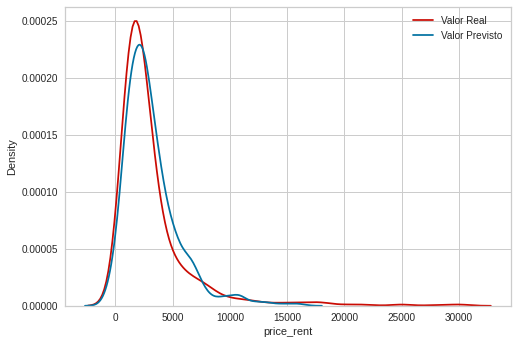

Treinando Modelo Lasso


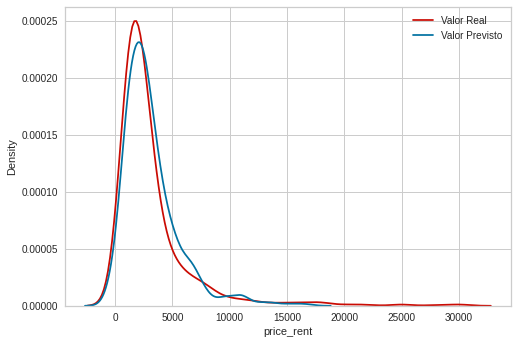

Treinando Modelo ElasticNet


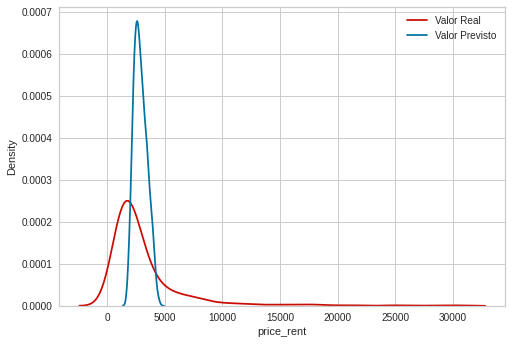

Treinando Modelo HuberRegressor


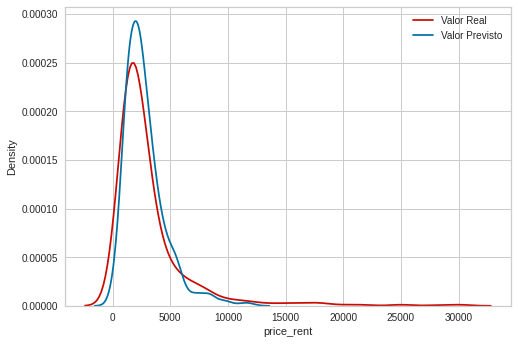

Treinando Modelo LGBMRegressor


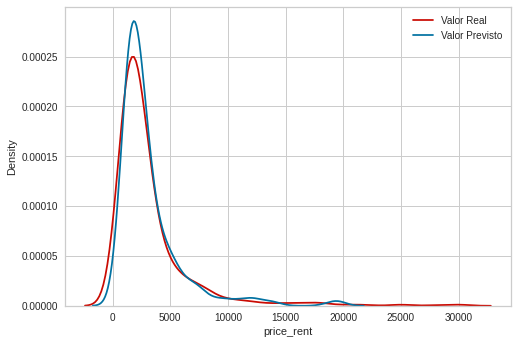

Treinando Modelo XGBRegressor


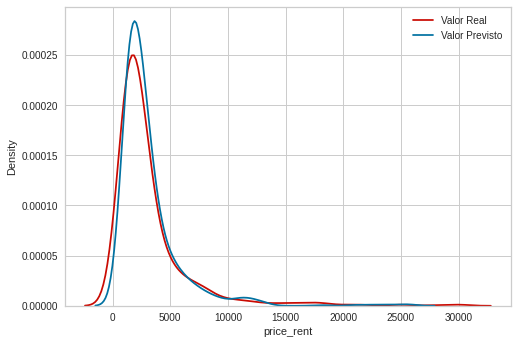

Treinando Modelo SVR


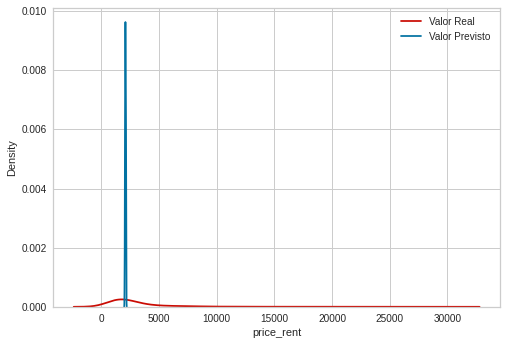

Treinando Modelo KNeighborsRegressor


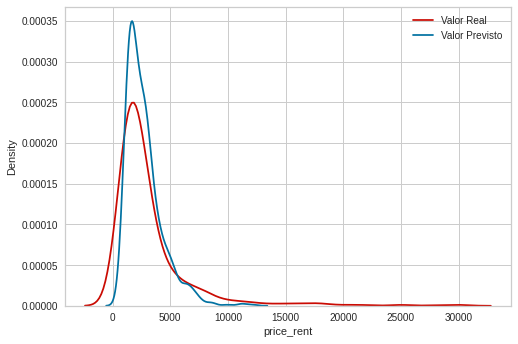

Treinando Modelo RandomForestRegressor


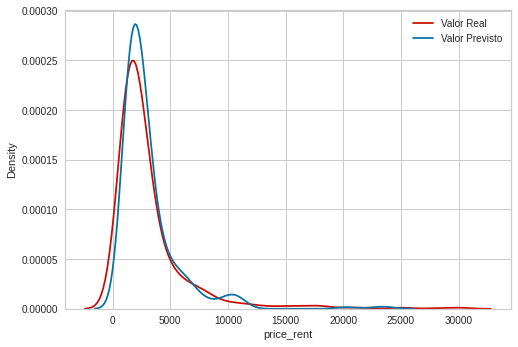

Treinando Modelo AdaBoostRegressor


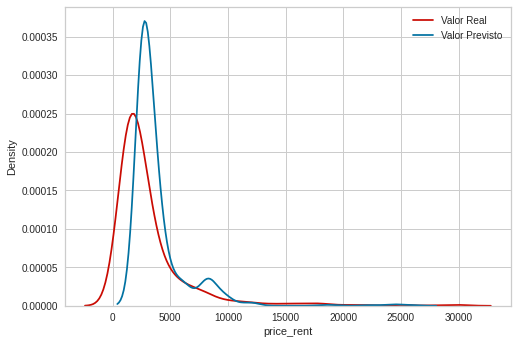

Treinando Modelo GradientBoostingRegressor


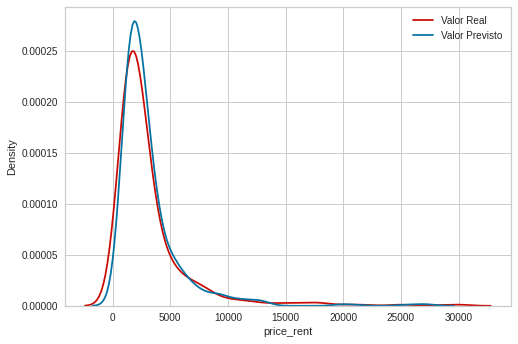

Treinando Modelo MLPRegressor


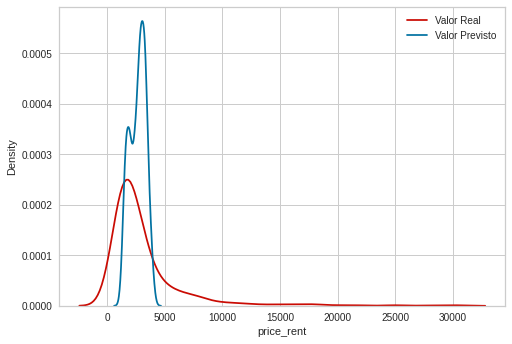

,R2,MAE,MSE,RMSE
XGBRegressor: normalized,0.739321,997.697849,3.265150e+06,1806.972580
GradientBoostingRegressor: normalized,0.734514,1000.357726,3.325361e+06,1823.557202
RandomForestRegressor: normalized,0.715769,1017.573956,3.560147e+06,1886.835169
LGBMRegressor: normalized,0.692967,1015.702449,3.845755e+06,1961.059659
Lasso: normalized,0.674684,1143.157110,4.074763e+06,2018.604221
RidgeCV: normalized,0.668273,1154.815049,4.155060e+06,2038.396359
AdaBoostRegressor: normalized,0.628397,1514.966824,4.654529e+06,2157.435747
HuberRegressor: normalized,0.560826,1148.118772,5.500886e+06,2345.396740
KNeighborsRegressor: normalized,0.341082,1404.709686,8.253301e+06,2872.855881
ElasticNet: normalized,0.166627,1691.536359,1.043845e+07,3230.858995


In [251]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Dataframe para armazenamento dos resultados
result_normalized = pd.DataFrame({})

# Aplicação dos modelos
for model in reg_list:
    print(f'Treinando Modelo {model.__class__.__name__}')
    model.fit(x_train_transformed, y_train)
    yHat = model.predict(x_test_transformed)
    
    train_score = model.score(x_train_transformed, y_train)
    cv_scores = cross_val_score(model, x_train_transformed, y_train)
    test_score = model.score(x_test_transformed, y_test)
    stats = pd.DataFrame({  
      'R2'    : r2_score(y_test, yHat),
      'MAE'    : mean_absolute_error(y_test, yHat),  
      'MSE'   : mean_squared_error(y_test, yHat), 
      'RMSE'  : np.sqrt(mean_squared_error(y_test, yHat))
      }, index = [f'{model.__class__.__name__}: normalized'])

    result_normalized = result_normalized.append([stats])


    ax1=sns.distplot(y_test, hist=False, color='r', label='Valor Real')
    sns.distplot(yHat, hist=False, ax=ax1, color='b', label='Valor Previsto')
    plt.legend()
    plt.show()
    print('='*80)

result_normalized.sort_values(by=['R2'], ascending = False)

Treinando Modelo RidgeCV


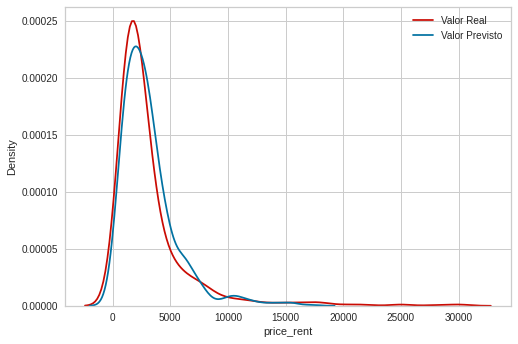

Treinando Modelo Lasso


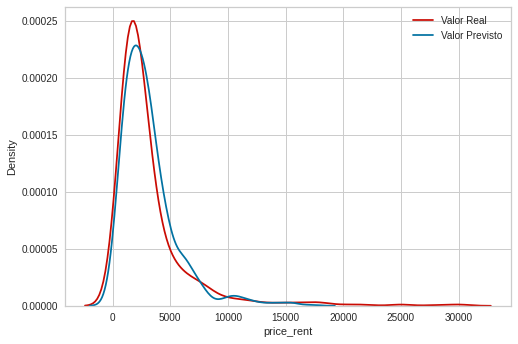

Treinando Modelo ElasticNet


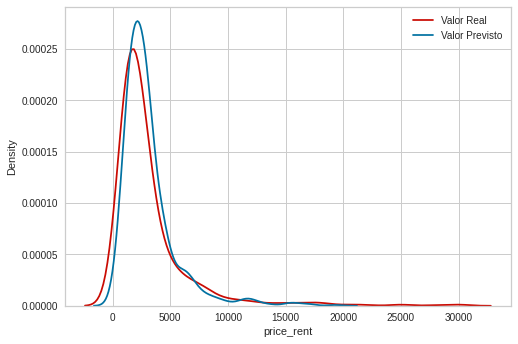

Treinando Modelo HuberRegressor


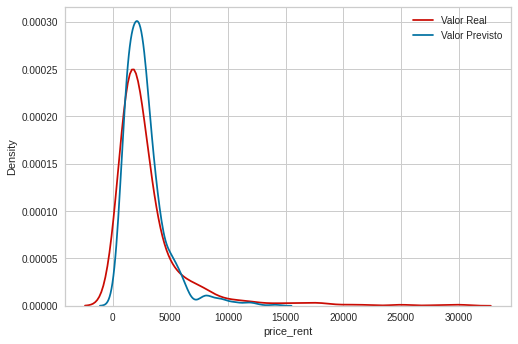

Treinando Modelo LGBMRegressor


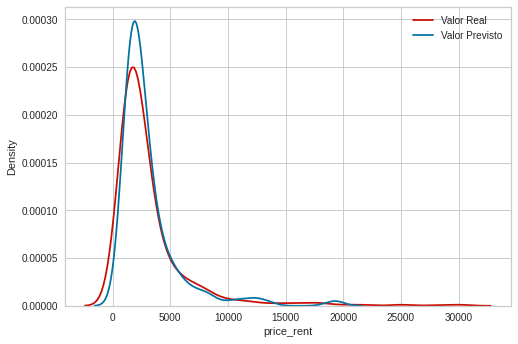

Treinando Modelo XGBRegressor


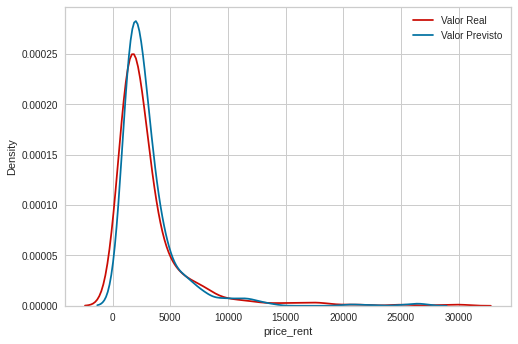

Treinando Modelo SVR


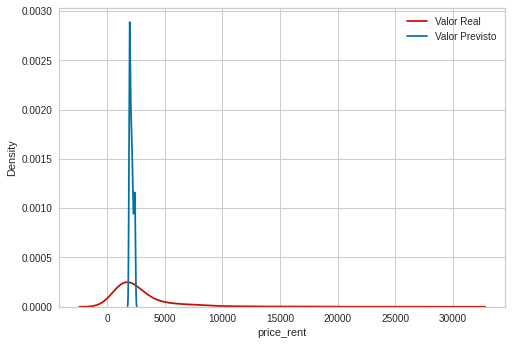

Treinando Modelo KNeighborsRegressor


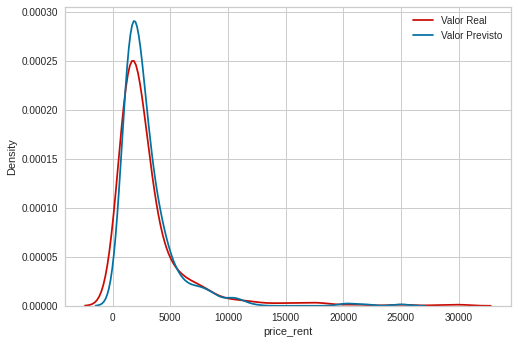

Treinando Modelo RandomForestRegressor


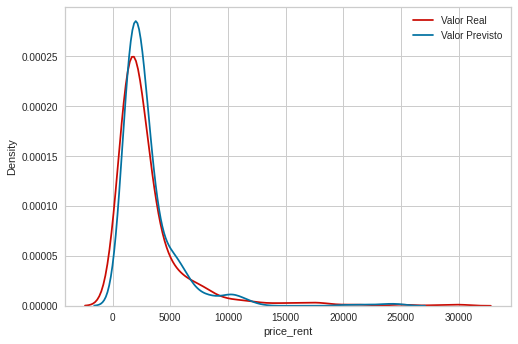

Treinando Modelo AdaBoostRegressor


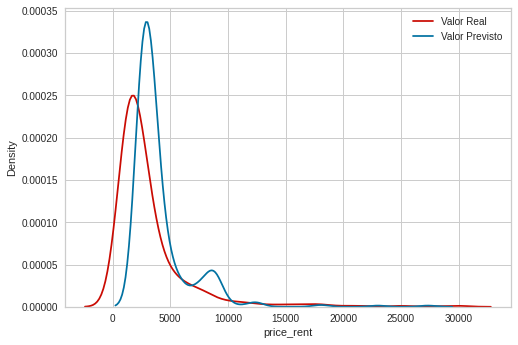

Treinando Modelo GradientBoostingRegressor


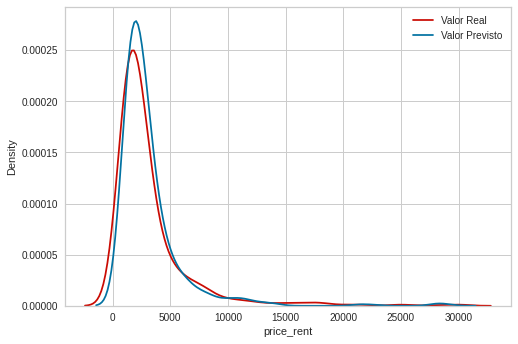

Treinando Modelo MLPRegressor


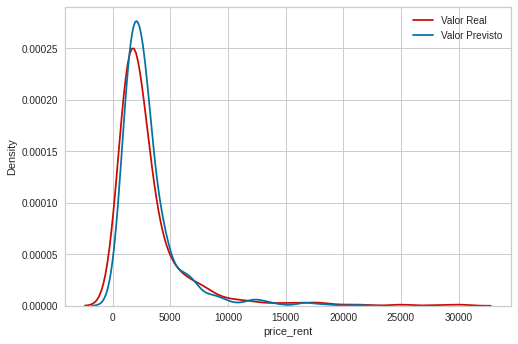

,R2,MAE,MSE,RMSE
XGBRegressor: best_features,0.716614,1069.241402,3.549562e+06,1884.028135
GradientBoostingRegressor: best_features,0.710083,1062.338404,3.631369e+06,1905.615109
RandomForestRegressor: best_features,0.699001,1101.173645,3.770180e+06,1941.695170
RidgeCV: best_features,0.663620,1197.073878,4.213343e+06,2052.642925
Lasso: best_features,0.663503,1196.026426,4.214802e+06,2052.998375
LGBMRegressor: best_features,0.659453,1120.992933,4.265538e+06,2065.317860
ElasticNet: best_features,0.638529,1234.143057,4.527618e+06,2127.820105
MLPRegressor: best_features,0.632852,1271.354743,4.598720e+06,2144.462568
KNeighborsRegressor: best_features,0.628802,1284.309937,4.649455e+06,2156.259608
AdaBoostRegressor: best_features,0.584665,1615.058535,5.202291e+06,2280.853174


In [252]:
# Setando as features alvo
x_target = df[best_features['feature'].unique()]
y_target = df['price_rent']

# Holdout
x_train, x_test, y_train, y_test = get_train_test(X=x_target, Y=y_target, test_size_p=0.3)

# Dataframe para armazenamento dos resultados
result_best_features = pd.DataFrame({})

# Aplicação dos modelos
for model in reg_list:
    print(f'Treinando Modelo {model.__class__.__name__}')
    model.fit(x_train, y_train)
    yHat = model.predict(x_test)
    
    train_score = model.score(x_train, y_train)
    cv_scores = cross_val_score(model, x_train, y_train)
    test_score = model.score(x_test, y_test)
    stats = pd.DataFrame({  
      'R2'    : r2_score(y_test, yHat),
      'MAE'    : mean_absolute_error(y_test, yHat),  
      'MSE'   : mean_squared_error(y_test, yHat), 
      'RMSE'  : np.sqrt(mean_squared_error(y_test, yHat))
      }, index = [f'{model.__class__.__name__}: best_features'])

    result_best_features = result_best_features.append([stats])
    ax1=sns.distplot(y_test, hist=False, color='r', label='Valor Real')
    sns.distplot(yHat, hist=False, ax=ax1, color='b', label='Valor Previsto')
    plt.legend()
    plt.show()
    print('='*80)

result_best_features.sort_values(by=['R2'], ascending = False)

Treinando Modelo RidgeCV


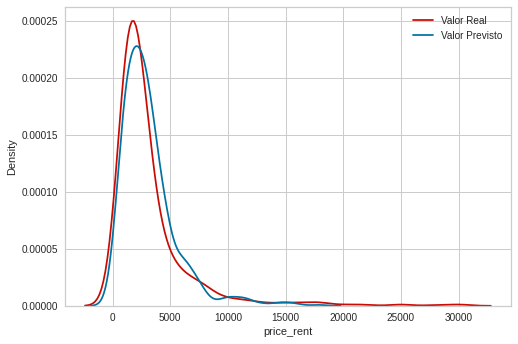

Treinando Modelo Lasso


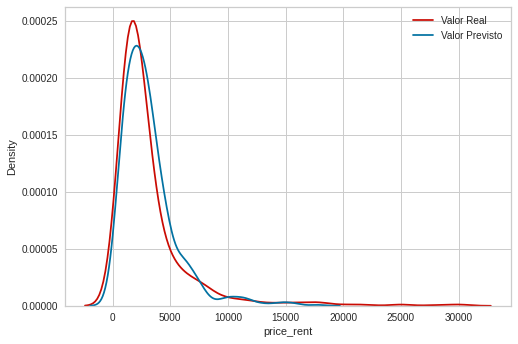

Treinando Modelo ElasticNet


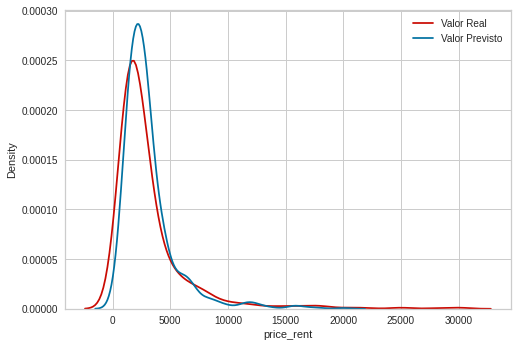

Treinando Modelo HuberRegressor


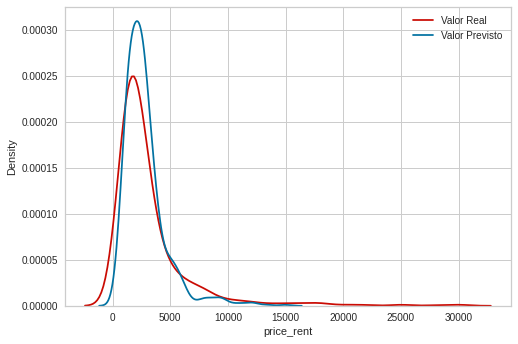

Treinando Modelo LGBMRegressor


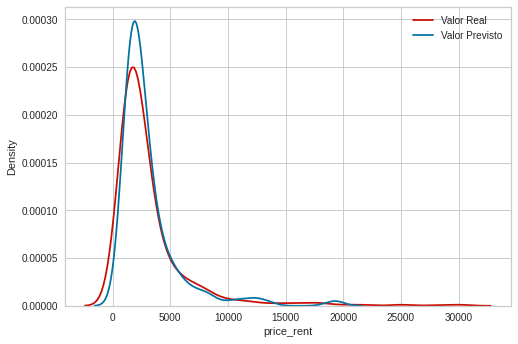

Treinando Modelo XGBRegressor


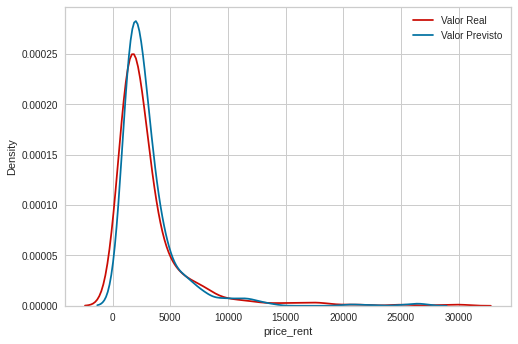

Treinando Modelo SVR


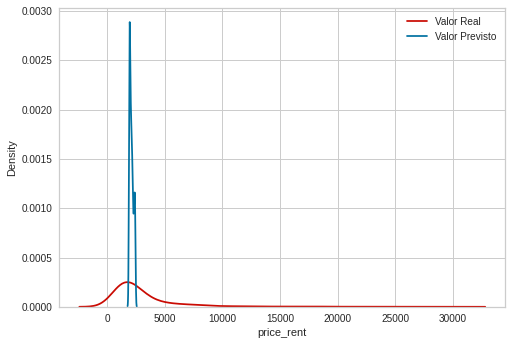

Treinando Modelo KNeighborsRegressor


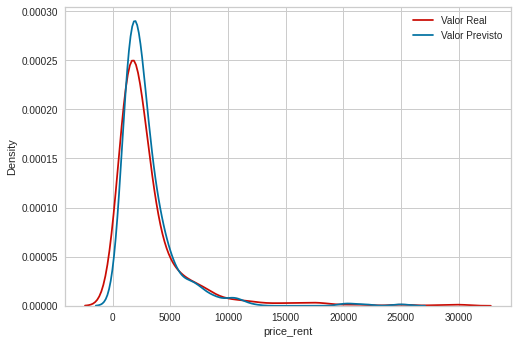

Treinando Modelo RandomForestRegressor


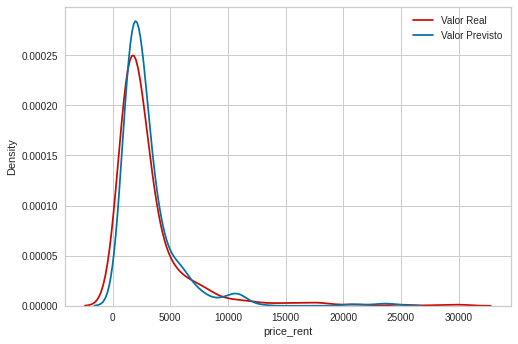

Treinando Modelo AdaBoostRegressor


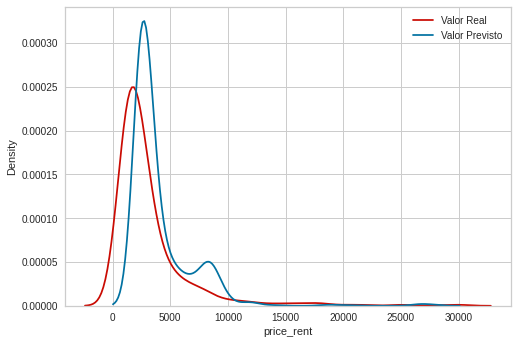

Treinando Modelo GradientBoostingRegressor


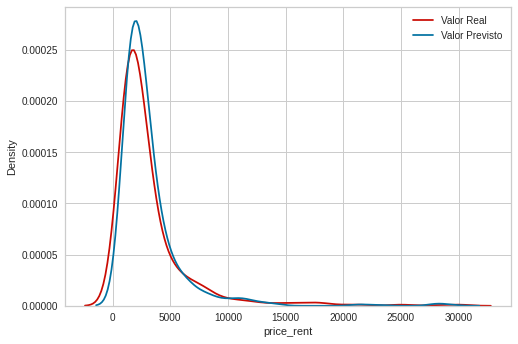

Treinando Modelo MLPRegressor


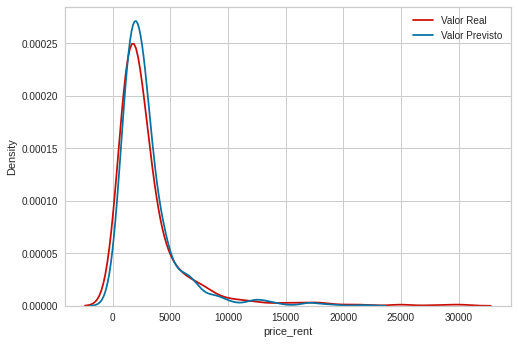

,R2,MAE,MSE,RMSE
XGBRegressor: log,0.716614,1069.241402,3.549562e+06,1884.028135
GradientBoostingRegressor: log,0.708602,1064.655820,3.649913e+06,1910.474456
RandomForestRegressor: log,0.706129,1097.017361,3.680896e+06,1918.566225
RidgeCV: log,0.660982,1203.157303,4.246376e+06,2060.673796
Lasso: log,0.660866,1203.926337,4.247841e+06,2061.029119
LGBMRegressor: log,0.659453,1120.992933,4.265538e+06,2065.317860
MLPRegressor: log,0.632153,1275.962006,4.607481e+06,2146.504454
ElasticNet: log,0.632134,1253.593817,4.607717e+06,2146.559337
KNeighborsRegressor: log,0.620036,1311.234717,4.759250e+06,2181.570548
AdaBoostRegressor: log,0.576929,1614.670057,5.299197e+06,2301.998383


In [253]:
# Tratamento dos dados por log
df[["area", "rooms", "bathrooms", "garage"]] = df[["area", "rooms", "bathrooms", "garage"]].apply(np.log1p)

# Setando as features alvo
x_target = df[best_features['feature'].unique()]
y_target = df['price_rent']

# Holdout
x_train, x_test, y_train, y_test = get_train_test(X=x_target, Y=y_target, test_size_p=0.3)

# Dataframe para armazenamento dos resultados
result_log = pd.DataFrame({})

# Aplicação dos modelos
for model in reg_list:
    print(f'Treinando Modelo {model.__class__.__name__}')

    model.fit(x_train, y_train)
    yHat = model.predict(x_test)
    
    train_score = model.score(x_train, y_train)
    cv_scores = cross_val_score(model, x_train, y_train)
    test_score = model.score(x_test, y_test)
    stats = pd.DataFrame({  
      'R2'    : r2_score(y_test, yHat),
      'MAE'    : mean_absolute_error(y_test, yHat),  
      'MSE'   : mean_squared_error(y_test, yHat), 
      'RMSE'  : np.sqrt(mean_squared_error(y_test, yHat))
      }, index = [f'{model.__class__.__name__}: log'])

    result_log = result_log.append([stats])
    ax1=sns.distplot(y_test, hist=False, color='r', label='Valor Real')
    sns.distplot(yHat, hist=False, ax=ax1, color='b', label='Valor Previsto')
    plt.legend()
    plt.show()
    print('='*80)

result_log.sort_values(by=['R2'], ascending = False)

In [254]:
# Concatenando os resultados de diferentes modelos com diferentes tratamentos
result = pd.concat([result_log, result_best_features, result_normalized])

# Ordenando os melhores modelos com base em seu score
result.sort_values(by=['R2'], ascending = False)

,R2,MAE,MSE,RMSE
XGBRegressor: normalized,0.739321,997.697849,3.265150e+06,1806.972580
GradientBoostingRegressor: normalized,0.734514,1000.357726,3.325361e+06,1823.557202
XGBRegressor: log,0.716614,1069.241402,3.549562e+06,1884.028135
XGBRegressor: best_features,0.716614,1069.241402,3.549562e+06,1884.028135
RandomForestRegressor: normalized,0.715769,1017.573956,3.560147e+06,1886.835169
GradientBoostingRegressor: best_features,0.710083,1062.338404,3.631369e+06,1905.615109
GradientBoostingRegressor: log,0.708602,1064.655820,3.649913e+06,1910.474456
RandomForestRegressor: log,0.706129,1097.017361,3.680896e+06,1918.566225
RandomForestRegressor: best_features,0.699001,1101.173645,3.770180e+06,1941.695170
LGBMRegressor: normalized,0.692967,1015.702449,3.845755e+06,1961.059659


o XGBoostRegressor com os dados normalizados através do MinMaxScaler e com a aplicação do OneHotEnconder foi o modelo com melhor desempenho entre todos os testados.

##**Ajustando Hiperparâmetros**

In [255]:
## Normalização das features númericas e aplicação do OneHotEncoder nas features categóricas
scaler = MinMaxScaler()
ohe = OneHotEncoder()

# Criando a variável data_pipeline para deixar na mesma ordem de grandeza minhas variáveis numericas
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features),
                                   ("categorical", ohe, categorical_features)],
                                  remainder="passthrough")

# Setando as features alvo
x = df[numerical_features + categorical_features + binary_features]
y = df[target]

# Holdout treino e teste
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size= .3, random_state=42)
data_pipeline.fit(x_train)
ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['area', 'rooms', 'bathrooms', 'garages']),
                                 ('categorical', OneHotEncoder(), ['city', 'estado'])])

# Transformando as minhas colunas na mesma ordem de grandeza
x_train_transformed = data_pipeline.transform(x_train)
x_test_transformed = data_pipeline.transform(x_test)


params = { 'max_depth': [2, 4, 6, 8],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.2, 0.6, 0.8],
           'min_child_weight': [3, 5, 7],
           'gamma': [0.3, 0.5, 0.7],
           'subsample': [0.4, 0.6, 0.8]}

model = XGBRegressor(objective='reg:squarederror')
grid = GridSearchCV(estimator=model, 
                   param_grid=params,
                   scoring='r2', 
                   verbose=1)
start = time.time()
grid.fit(x_train_transformed, y_train)
end = time.time()

print("Best parameters:", grid.best_params_)
print("Best Score (R2): ", (grid.best_score_))

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.3, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Score (R2):  0.6909767940121725


In [283]:
from sklearn.model_selection import 

# Números de árvores a serem usadas
xgb_n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]

# Número máximo de niveis na árvore
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]

# Número mínimo de instâncias em cada nó
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]

# Construção da árvore usada no XGBoost
xgb_tree_method = ['auto', 'exact', 'approx', 'hist', 'gpu_hist']

# Taxa de aprendizagem
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]

# Redução de perda mínima necessária para fazer mais partição
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]

# Objetivo de aprendizagem usado
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Criando os parâmetros
params = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}

reg = XGBRegressor()

# Rodando a busca por parâmetros
n_iter_search = 100
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, n_jobs=-1)

start = time.time()
random_search.fit(x_train_transformed, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
print("Best parameters:", random_search.best_params_)
print("Best Score (R2): ", (random_search.best_score_))

RandomizedSearchCV took 3923.04 seconds for 100 candidates parameter settings.
Best parameters: {'tree_method': 'exact', 'objective': 'reg:squarederror', 'n_estimators': 1600, 'min_child_weight': 2, 'max_depth': 6, 'gamma': 0, 'eta': 0.4}
Best Score (R2):  0.6596886038323998


Tanto no GrindSearchCV quando no RandomizedSearchCV o modelo não apresentou melhoras de desempenho em comparação ao seus parâmetros padrões.

##**Salvando o Modelo**

In [259]:
## Normalização das features númericas e aplicação do OneHotEncoder nas features categóricas
scaler = MinMaxScaler()
ohe = OneHotEncoder()

# Criando a variável data_pipeline para deixar na mesma ordem de grandeza minhas variáveis numericas
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features),
                                   ("categorical", ohe, categorical_features)],
                                  remainder="passthrough")

# Setando as features alvo
x = df[numerical_features + categorical_features + binary_features]
y = df[target]

# Holdout treino e teste
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size= .3, random_state=42)
data_pipeline.fit(x_train)
ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['area', 'rooms', 'bathrooms', 'garages']),
                                 ('categorical', OneHotEncoder(), ['city', 'estado'])])

# Transformando as minhas colunas na mesma ordem de grandeza
x_train_transformed = data_pipeline.transform(x_train)
x_test_transformed = data_pipeline.transform(x_test)


model = XGBRegressor(objective='reg:squarederror')
model.fit(x_train_transformed, y_train)
yHat = model.predict(x_test_transformed)

In [272]:
pickle.dump(model, open('drive/MyDrive/regressor.pkl', 'wb'))